In [1]:
import numpy as np
import sklearn as skl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')
%matplotlib notebook

## Simulated 2-Class Data

This will be 2-normally distributed clusters. The data is not completely linearly separable but they have some separation. We pick a mean to center our "negative examples" around and a second mean to center our "positive examples". In this example the negative examples have a larger standard deviation.


In [2]:
samples = 1000

# Alwasy setting the seed
# so run is reproducible
data_seed = 42
np.random.seed(data_seed)

# 2D-mean of the negative then respectively positive cluster
classMeans = np.vstack([np.array([-1,1]),np.array([1,-1])])
# Std of the negative then respectively positive cluster
classStd = [0.75,.5]

# Coinflip to determine whether a sample is negative or positive
y = np.array([np.random.randint(0,2) for sample in range(samples)])
# Based on the class we pick the mean and add some normal random noise
X = np.array([classMeans[label,:] + np.random.randn(2)*classStd[label] 
             for label in y])



### Visualizing our Simulated Data

Note we use good matplotlib form here and avoid calling "plt" directly. This shows the two clusters. 

<IPython.core.display.Javascript object>


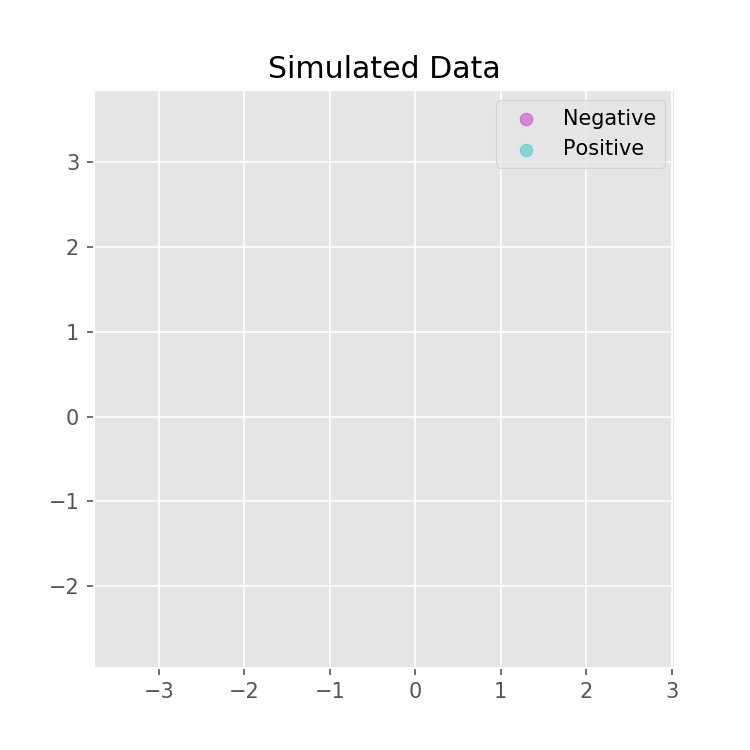

In [3]:
# Get the max and min of the data
X_min, X_max = X.max(axis=0), X.min(axis=0)
# Give a margin so the data sits inside a box where the probability
# shows up
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# P are points the classifier thinks are postive
# N are points the classifier thinks are negative
# These are graphic styles
N_kwargs=dict(c='m',animated=True,zorder=2,alpha=0.4,label="Negative")
P_kwargs=dict(c='c',animated=True,zorder=5,alpha=0.4,label="Positive")

# Figure paremeters
# Used throughtout
fig_kwargs = dict(figsize=(5,5),dpi=150)
# Make the fig
fig, ax = plt.subplots(**fig_kwargs)
ax.set(xlim=(x_min,x_max), ylim=(y_min,y_max))
ax.margins(0.2)
ax.set_title("Simulated Data")
scats = [ax.scatter(X[y==0,0],X[y==0,1],**N_kwargs),
         ax.scatter(X[y==1,0],X[y==1,1],**P_kwargs)]
ax.legend(); # To suppress the print


## Logistic Regression Classifier

We start out with a simple neural network which includes an input node for each of 2 dimensions $x_1, x_2$, and a single output node. In this network we have two weights $w_1,w_2$ corresponding to the input nodes, and a bias term $b$. The sigmoid activation is given by

$$h(z) = \frac{1}{1-e^{-z}}.$$

If we make vectors $\theta = (w_1, w_2, b)$ and $x = (x_1, x_2, 1)$ then we can write the prediction of a classifier determined by $\theta$ for input data $x$ is 

$$h_\theta(x) = \frac{1}{1-e^{-\theta^Tx}}$$

where $\theta^Tx$ is the dot product of $\theta$ and $x$, in other words $\theta^Tx = x_1w_1 + x_2 w_2 + b$. The prediction $h_\theta(x)$ is the classifiers estimate that $x$ is in the positive class. 

The key thing is to determine a good $\theta$ that estimates these probabilities well. We will learn the best $\theta$ using gradient decent. But to start lets just choose random values for $\theta$.

In [4]:
# Always seed when using random for reproducibility
seed = 56
np.random.seed(seed)

# Now we pick random weights and bias to start with
weights_0 = np.random.randn(2)
bias_0 = np.random.randn(1)

In [5]:
# In order to visualize the classifier, we will use the matlab countourf
# function to create a heat map that shows the probability in-between the
# data points. This means we need to make a grid of samples to test the
# probability. Since this classifier is we don't need alot of points
h = .2  # step size in the mesh
# This makes 2-D grids of x and respectively y coorindates
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#This is where we set the color map
#for the heat map. Currently set red to blue
cm = plt.cm.RdBu

# Because we call this many times and repeatedly in the
# animation code below, it is best to set all the color
# and visual properties for the data points

# FN are points the classifier thinks are negative but are positive
FN_kwargs = dict(animated=True,               
                s=50,
                edgecolors='c',
                linewidths=2,
                facecolors='none',
                marker='o',
                zorder=20,
                alpha=0.8,
                label='False Negative')
# FN are points the classifier thinks are positive but are negative
FP_kwargs = dict(animated=True,               
                s=50,
                edgecolors='m',
                linewidths=2,
                facecolors='none',
                marker='o',
                zorder=10,
                alpha=0.8,
                label='False Positive')


In [6]:
# logistic sigmoid activation
def sigmoid(z):
    """Logistic Sigmoid"""
    return (np.exp(z*(-1.0))+1)**(-1)  

In [7]:
# Feed Forward 
def predict(X, weights, bias):
    """Logistic Sigmoid Prediction"""
    return sigmoid(np.dot(X,weights)+ bias)

In [8]:
# Here we actually make predictions on the data X
# y_pred are the predicted probabilities of being postive
# y_pred = predict(X, weights, bias)
# Here we use 0.5 to threshold and make a decision that the label is positive
# y_pred_label = y_pred> 0.5

In [9]:
# We use a cross entropy loss. This is corresponds to asking what 
# is the probability that the data we see could have come from
# a distribution with the probabilites we predicted.
def cross_entropy_loss(y,y_pred):
    """Loss based on negative log-likelihood of the data.
    Target values passed in first.
    """
    loss=np.zeros(y.shape[0])
    loss[y==1]= - np.log(y_pred[y==1])
    loss[y!=1]= - np.log(1-y_pred[y!=1])
    return loss.mean()

<IPython.core.display.Javascript object>


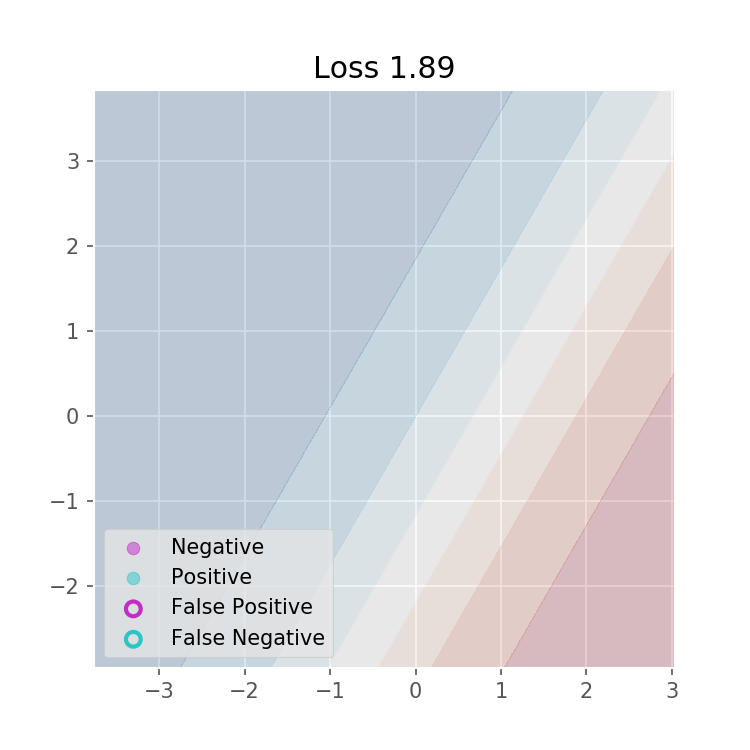

In [10]:
# This is an all-in-one function that goes from Data to visualization of
# prediction. Note you need to give it the weights and bias.

def show_classification(X,y,weights,bias):
    y_pred = predict(X, weights, bias) 
    y_pred_label = y_pred> 0.5
    loss = cross_entropy_loss(y,y_pred)
    fig, ax = plt.subplots(**fig_kwargs)
    ax.set_title("Loss {:03.2f}".format(loss))
    Z = predict(np.c_[xx.ravel(),yy.ravel()], weights, bias)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx,yy,Z,cmap=cm, alpha=.2)
    ax.scatter(X[y_pred_label==0,0],X[y_pred_label==0,1],**N_kwargs)
    ax.scatter(X[y_pred_label==1,0],X[y_pred_label==1,1],**P_kwargs)
    ax.scatter(X[np.logical_and(y_pred_label==1, y == 0),0],
               X[np.logical_and(y_pred_label==1, y == 0),1],
               **FP_kwargs)
    ax.scatter(X[np.logical_and(y_pred_label==0, y == 1),0],
               X[np.logical_and(y_pred_label==0, y == 1),1],
               **FN_kwargs)
    ax.legend()
    plt.show()
    return fig, ax

# Lets see an example with the random weights we choose. 
_ = show_classification(X,y,weights_0,bias_0)

## Gradient Decent

We first compute the gradient of the loss with respect to the space of weight and bias parameters. To perform gradient decent we compute this gradient with respect to all the training examples.

In [ ]:
def gradient(X, y, weights, bias):
    num_obs, num_feats = X.shape
    y_pred = predict(X, weights, bias)
    errors = (y_pred - y).reshape(num_obs,1)
    return np.hstack([(X*errors).mean(axis=0),np.array(errors.mean())])


Here we will compute one step of gradient decent using all training examples. Note the loss drops.

In [ ]:
# Gradient with respect to all the training examples
grad = gradient(X, y, weights_0, bias_0)

learning_rate = 0.1
weights_1, bias_1 = weights_0 - learning_rate*grad[:2], bias_0 - learning_rate*grad[2]
_ = show_classification(X,y,weights_1,bias_1)


### Gradient Decent Procedure

Now we set up a procedure to apply gradient decent until the solution stabilizes or a max number of iterations is reached.

In [ ]:

def gradient_decent():
    """Proceedure to perform and visualize gradient decent for Logisit Regression on X,y"""
    np.random.seed(seed)
    weights = np.random.randn(2)
    bias = np.random.randn(1)
    learning_rate = 0.1
    MAX_EPOCS = 100
    term_epsilon = 10**(-5)

    # initialize data series
    losses_, N_series_, P_series_,FN_series_, FP_series_, Zseq_  = [],[],[],[],[],[]
    for loop in range(MAX_EPOCS):
        grad = gradient(X, y, weights, bias)
        weights_new, bias_new = weights - learning_rate*grad[:2], bias - learning_rate*grad[2]
        if ((weights-weights_new)**2 + (bias-bias_new)**2).mean() < term_epsilon:
            break
        else:
            weights, bias = weights_new, bias_new
            y_pred = predict(X, weights, bias) 
            y_pred_label = y_pred> 0.5
            losses_.append(cross_entropy_loss(y,y_pred))
            N_series_.append(X[y_pred_label==0,:])
            P_series_.append(X[y_pred_label==1,:])
            FN_series_.append(X[np.logical_and(y_pred_label==0, y == 1),:])
            FP_series_.append(X[np.logical_and(y_pred_label==1, y == 0),:])
            Z = predict(np.c_[xx.ravel(),yy.ravel()], weights, bias)
            Zseq_.append(Z.reshape(xx.shape))
            
    return losses_, N_series_, P_series_, FN_series_, FP_series_, Zseq_

losses, N_series, P_series, FN_series, FP_series, Zseq = gradient_decent()

In [ ]:
%%capture
vga = (640,460)
ani_fig_kwargs = fig_kwargs
ani_fig_kwargs['dpi']=100
ani_fig_kwargs['figsize']= (vga[0]/ani_fig_kwargs['dpi'], vga[1]/ani_fig_kwargs['dpi'])
fig, axs = None, None
fig, axs = plt.subplots(nrows=1, ncols=2, **ani_fig_kwargs)
heat_map_kwargs = dict(cmap=cm, alpha=.2,zorder=1)
errorPlt = None

def init_animate():
    global errorPlt
    global fig, axs
    P_scatter = axs[0].scatter([], [], **P_kwargs)
    N_scatter = axs[0].scatter([], [], **N_kwargs)
    FN_scatter = axs[0].scatter([], [], **FN_kwargs)
    FP_scatter = axs[0].scatter([], [], **FP_kwargs)
    errorPlt, = axs[1].plot([],[],'k',animated=True)
    axs[0].axis([X_min[0],X_max[0],X_min[1],X_max[1]])
    axs[1].axis([1,len(losses),min(losses),max(losses)])
    axs[0].set_aspect('equal')
    axs[1].set_aspect(len(losses)/(max(losses)-min(losses)))
    axs[1].set_title("Training Error")
    axs[1].set_xlabel("Iteration")
    
def animate(i):
    axs[0].collections = []
    axs[1].collections = []
    axs[0].contourf(xx,yy,Zseq[i],**heat_map_kwargs)
    axs[0].scatter(N_series[i][:,0],N_series[i][:,1],**N_kwargs)
    axs[0].scatter(P_series[i][:,0],P_series[i][:,1],**P_kwargs)
    axs[0].scatter(FN_series[i][:,0],FN_series[i][:,1],**FN_kwargs)
    axs[0].scatter(FP_series[i][:,0],FP_series[i][:,1],**FP_kwargs)
    axs[0].set_title("Loss {:03.2f}".format(losses[i]))
    axs[1].plot(range(i),losses[:i],'k',animated=True)
    #errorPlt.set_data(range(i),losses[:i])
    return errorPlt
 


In [ ]:
ani = FuncAnimation(fig, animate, init_func=init_animate, frames=len(losses))
HTML(ani.to_jshtml())

In [ ]:
ani.save("LRanimation.mov")

## Stocastic Gradient Descent 

Rather than applying gradient decent to the whole data set we can apply it to each data point as it comes in. This will ultimately require more iterations but each interation will be a fraction of the time required for full gradient descent.

In [ ]:
def stocastic_gradient_decent():
    """Proceedure to perform and visualize gradient decent for Logisit Regression on X,y"""
    np.random.seed(seed)
    weights = np.random.randn(2)
    bias = np.random.randn(1)
    learning_rate = 0.1
    MAX_EPOCS = 10
    term_epsilon = 10**(-5)
    Xsz = X.shape

    # initialize data series
    losses_, N_series_, P_series_,FN_series_, FP_series_, Zseq_  = [],[],[],[],[],[]
    break_epocs = False
    for loop in range(MAX_EPOCS):
        for row,label in zip(X,y):
            row = row.reshape((1,Xsz[-1]))
            grad = gradient(row, label, weights, bias)
            weights_new, bias_new = weights - learning_rate*grad[:2], bias - learning_rate*grad[2]
            if ((weights-weights_new)**2 + (bias-bias_new)**2).mean() < term_epsilon:
                print("Stable Threshold")
                break_epocs = True
                break
            else:
                weights, bias = weights_new, bias_new
                y_pred = predict(X, weights, bias) 
                y_pred_label = y_pred> 0.5
                losses_.append(cross_entropy_loss(y,y_pred))
                N_series_.append(X[y_pred_label==0,:])
                P_series_.append(X[y_pred_label==1,:])
                FN_series_.append(X[np.logical_and(y_pred_label==0, y == 1),:])
                FP_series_.append(X[np.logical_and(y_pred_label==1, y == 0),:])
                Z = predict(np.c_[xx.ravel(),yy.ravel()], weights, bias)
                Zseq_.append(Z.reshape(xx.shape))
        if break_epocs:
            break
            
    return losses_, N_series_, P_series_, FN_series_, FP_series_, Zseq_

losses, N_series, P_series, FN_series, FP_series, Zseq = stocastic_gradient_decent()

In [ ]:
%%capture
vga = (640,460)
ani_fig_kwargs = fig_kwargs
ani_fig_kwargs['dpi']=100
ani_fig_kwargs['figsize']= (vga[0]/ani_fig_kwargs['dpi'], vga[1]/ani_fig_kwargs['dpi'])
fig, axs = None, None
fig, axs = plt.subplots(nrows=1, ncols=2, **ani_fig_kwargs)
heat_map_kwargs = dict(cmap=cm, alpha=.2,zorder=1)
errorPlt = None

def init_animate():
    global errorPlt
    global fig, axs
    P_scatter = axs[0].scatter([], [], **P_kwargs)
    N_scatter = axs[0].scatter([], [], **N_kwargs)
    FN_scatter = axs[0].scatter([], [], **FN_kwargs)
    FP_scatter = axs[0].scatter([], [], **FP_kwargs)
    errorPlt, = axs[1].plot([],[],'k',animated=True)
    axs[0].axis([X_min[0],X_max[0],X_min[1],X_max[1]])
    axs[1].axis([1,len(losses),min(losses),max(losses)])
    axs[0].set_aspect('equal')
    axs[1].set_aspect(len(losses)/(max(losses)-min(losses)))
    axs[1].set_title("Training Error")
    axs[1].set_xlabel("Iteration")
    
def animate(i):
    axs[0].collections = []
    axs[1].collections = []
    axs[0].contourf(xx,yy,Zseq[i],**heat_map_kwargs)
    axs[0].scatter(N_series[i][:,0],N_series[i][:,1],**N_kwargs)
    axs[0].scatter(P_series[i][:,0],P_series[i][:,1],**P_kwargs)
    axs[0].scatter(FN_series[i][:,0],FN_series[i][:,1],**FN_kwargs)
    axs[0].scatter(FP_series[i][:,0],FP_series[i][:,1],**FP_kwargs)
    axs[0].set_title("Loss {:03.2f}".format(losses[i]))
    axs[1].plot(range(i),losses[:i],'k',animated=True)
    #errorPlt.set_data(range(i),losses[:i])
    return errorPlt
 
    

In [ ]:
ani = FuncAnimation(fig, animate, init_func=init_animate, frames=len(losses))
HTML(ani.to_jshtml())

## Batch Stocastic Gradient Decent

A small variant of the previous version is to do go in batches. This is much faster than gradient decent but much smoother than stacastic gradient decent.

In [ ]:
def batch_stocastic_gradient_decent(batch_size=50):
    """Proceedure to perform and visualize gradient decent for Logisit Regression on X,y"""
    np.random.seed(seed)
    weights = np.random.randn(2)
    bias = np.random.randn(1)
    learning_rate = 0.1
    MAX_EPOCS = 10
    term_epsilon = 10**(-5)
    Xsz = X.shape

    # initialize data series
    losses_, N_series_, P_series_,FN_series_, FP_series_, Zseq_  = [],[],[],[],[],[]
    break_epocs = False
    batch_inds = range(1,Xsz[0],batch_size)
    for loop in range(MAX_EPOCS):
        for start_batch, end_batch in zip(batch_inds[:-1],batch_inds[1:]):
            grad = gradient(X[start_batch:end_batch], y[start_batch:end_batch], weights, bias)
            weights_new, bias_new = weights - learning_rate*grad[:2], bias - learning_rate*grad[2]
            if ((weights-weights_new)**2 + (bias-bias_new)**2).mean() < term_epsilon:
                print("Stable Threshold")
                break_epocs = True
                break
            else:
                weights, bias = weights_new, bias_new
                y_pred = predict(X, weights, bias) 
                y_pred_label = y_pred> 0.5
                losses_.append(cross_entropy_loss(y,y_pred))
                N_series_.append(X[y_pred_label==0,:])
                P_series_.append(X[y_pred_label==1,:])
                FN_series_.append(X[np.logical_and(y_pred_label==0, y == 1),:])
                FP_series_.append(X[np.logical_and(y_pred_label==1, y == 0),:])
                Z = predict(np.c_[xx.ravel(),yy.ravel()], weights, bias)
                Zseq_.append(Z.reshape(xx.shape))
        if break_epocs:
            break
            
    return losses_, N_series_, P_series_, FN_series_, FP_series_, Zseq_

losses, N_series, P_series, FN_series, FP_series, Zseq = stocastic_gradient_decent()

In [ ]:
%%capture
vga = (640,460)
ani_fig_kwargs = fig_kwargs
ani_fig_kwargs['dpi']=100
ani_fig_kwargs['figsize']= (vga[0]/ani_fig_kwargs['dpi'], vga[1]/ani_fig_kwargs['dpi'])
fig, axs = None, None
fig, axs = plt.subplots(nrows=1, ncols=2, **ani_fig_kwargs)
heat_map_kwargs = dict(cmap=cm, alpha=.2,zorder=1)
errorPlt = None

def init_animate():
    global errorPlt
    global fig, axs
    P_scatter = axs[0].scatter([], [], **P_kwargs)
    N_scatter = axs[0].scatter([], [], **N_kwargs)
    FN_scatter = axs[0].scatter([], [], **FN_kwargs)
    FP_scatter = axs[0].scatter([], [], **FP_kwargs)
    errorPlt, = axs[1].plot([],[],'k',animated=True)
    axs[0].axis([X_min[0],X_max[0],X_min[1],X_max[1]])
    axs[1].axis([1,len(losses),min(losses),max(losses)])
    axs[0].set_aspect('equal')
    axs[1].set_aspect(len(losses)/(max(losses)-min(losses)))
    axs[1].set_title("Training Error")
    axs[1].set_xlabel("Iteration")
    
def animate(i):
    axs[0].collections = []
    axs[1].collections = []
    axs[0].contourf(xx,yy,Zseq[i],**heat_map_kwargs)
    axs[0].scatter(N_series[i][:,0],N_series[i][:,1],**N_kwargs)
    axs[0].scatter(P_series[i][:,0],P_series[i][:,1],**P_kwargs)
    axs[0].scatter(FN_series[i][:,0],FN_series[i][:,1],**FN_kwargs)
    axs[0].scatter(FP_series[i][:,0],FP_series[i][:,1],**FP_kwargs)
    axs[0].set_title("Loss {:03.2f}".format(losses[i]))
    axs[1].plot(range(i),losses[:i],'k',animated=True)
    #errorPlt.set_data(range(i),losses[:i])
    return errorPlt
 

In [ ]:
ani = FuncAnimation(fig, animate, init_func=init_animate, frames=len(losses))
HTML(ani.to_jshtml())